In [2]:
!pip install clip-by-openai
!pip install torch torchvision
!pip install scikit-learn
!pip install Pillow numpy
!pip install git+https://github.com/openai/CLIP.git



INFO: pip is looking at multiple versions of clip-by-openai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of clip-by-openai to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install clip-by-openai==0.1.0, clip-by-openai==0.1.1, clip-by-openai==0.1.1.2, clip-by-openai==0.1.1.3, clip-by-openai==0.1.1.4, clip-by-openai==0.1.1.5, clip-by-openai==1.0.1 and clip-by-openai==1.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    clip-by-openai 1.1 depends on torch<1.7.2 and >=1.7.1
    clip-by-openai 1.0.1 depends on torch<1.7.2 and >=1.7.1
    clip-by-openai 0.1.1.5 depends on torch==1.7.1
    clip-by-openai 0.1.1.4 depends on torch==1.7.1
    clip-by-openai 0.1.1.3 depends on torch==1.7.1
    clip-by-openai 0.1.1.2 depends on torch==1.7.1
    clip-by-openai 0.1.1 depends on torch==1.7.1
    clip-by-opena

In [4]:
!pip install transformers


In [5]:
import os
import shutil
import random
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import torch
import clip
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cpu


In [6]:
model, preprocess = clip.load("ViT-B/32", device=device)


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 199MiB/s]


In [15]:
# Cell 3: Load dữ liệu 5 loài & chia tạm
data_dir = "/kaggle/input/data-animal-5/animals5_100"  # thay bằng path thật trong Kaggle
species_classes = ["cat", "dog", "cattle", "chicken", "elephant"]
splits = {"train": 0.6, "val": 0.2, "test": 0.2}

# Dict lưu đường dẫn ảnh
data_split = {split: {cls: [] for cls in species_classes} for split in splits}

for cls in species_classes:
    cls_path = os.path.join(data_dir, cls)
    imgs = glob(os.path.join(cls_path, "*.*"))
    random.shuffle(imgs)
    n = len(imgs)
    train_end = int(splits["train"]*n)
    val_end = train_end + int(splits["val"]*n)
    
    data_split["train"][cls] = imgs[:train_end]
    data_split["val"][cls] = imgs[train_end:val_end]
    data_split["test"][cls] = imgs[val_end:]

# Kiểm tra
for split in splits:
    print(f"{split.upper()} set:")
    for cls in species_classes:
        print(f"  {cls:<10}: {len(data_split[split][cls])} ảnh")


TRAIN set:
  cat       : 60 ảnh
  dog       : 60 ảnh
  cattle    : 60 ảnh
  chicken   : 60 ảnh
  elephant  : 60 ảnh
VAL set:
  cat       : 20 ảnh
  dog       : 20 ảnh
  cattle    : 20 ảnh
  chicken   : 20 ảnh
  elephant  : 20 ảnh
TEST set:
  cat       : 20 ảnh
  dog       : 20 ảnh
  cattle    : 20 ảnh
  chicken   : 20 ảnh
  elephant  : 20 ảnh


In [16]:
# Cell 4: Tạo text embedding cho 5 loài + breed
species_tokens = clip.tokenize(species_classes).to(device)
with torch.no_grad():
    species_text_features = model.encode_text(species_tokens)
    species_text_features /= species_text_features.norm(dim=-1, keepdim=True)

# Zero-shot: breed prediction (chỉ cho mèo & chó)
dog_breeds = ['Abyssinian', 'Bengal', 'Birman', 'Maine_Coon', 'Siamese']
cat_breeds = ['french_bulldog', 'german_shepherd', 'golden_retriever', 'poodle', 'yorkshire_terrier']
all_breeds = dog_breeds + cat_breeds

breed_tokens = clip.tokenize(all_breeds).to(device)
with torch.no_grad():
    breed_text_features = model.encode_text(breed_tokens)
    breed_text_features /= breed_text_features.norm(dim=-1, keepdim=True)


In [19]:
# Cell 5: Hàm dự đoán species hoặc breed
def predict_species(img_path):
    image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        img_feat = model.encode_image(image)
        img_feat /= img_feat.norm(dim=-1, keepdim=True)
        sim = (img_feat @ species_text_features.T).squeeze(0)
        return species_classes[sim.topk(1).indices.item()]

def predict_breed(img_path):
    image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        img_feat = model.encode_image(image)
        img_feat /= img_feat.norm(dim=-1, keepdim=True)
        sim = (img_feat @ breed_text_features.T).squeeze(0)
        return all_breeds[sim.topk(1).indices.item()]


In [20]:
# Cell 6: Đánh giá
def evaluate_split(data_split, split, predict_fn):
    all_preds, all_labels = [], []
    acc_dict = {}
    for cls, img_list in data_split[split].items():
        if len(img_list) == 0:
            acc_dict[cls] = 0
            continue
        correct = 0
        for img_path in img_list:
            pred = predict_fn(img_path)
            all_preds.append(pred)
            all_labels.append(cls)
            if cls.lower() in pred.lower():
                correct += 1
        acc = correct / len(img_list)
        acc_dict[cls] = acc
    overall_acc = sum([len(data_split[split][cls])*acc_dict[cls] for cls in species_classes]) / \
                  sum([len(data_split[split][cls]) for cls in species_classes])
    return acc_dict, overall_acc, all_preds, all_labels


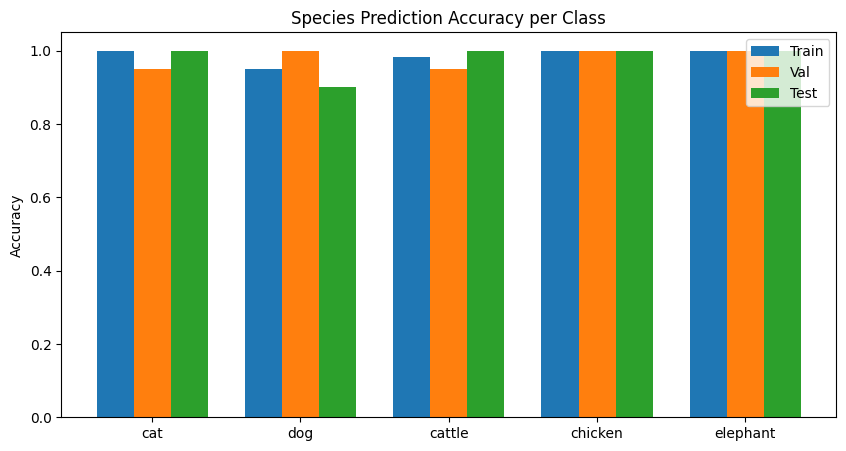

,train,val,test
cat,1.000000,0.95,1.00
dog,0.950000,1.00,0.90
cattle,0.983333,0.95,1.00
chicken,1.000000,1.00,1.00
elephant,1.000000,1.00,1.00
Overall,0.986667,0.98,0.98


In [21]:
# Cell 7: Evaluate toàn bộ & vẽ biểu đồ thanh
results = {}
overall = {}

for split in splits:
    acc_dict, overall_acc, preds, labels = evaluate_split(data_split, split, predict_species)
    results[split] = acc_dict
    overall[split] = overall_acc

# Bar chart
x = np.arange(len(species_classes))
width = 0.25
plt.figure(figsize=(10,5))
plt.bar(x - width, [results["train"][cls] for cls in species_classes], width, label='Train')
plt.bar(x, [results["val"][cls] for cls in species_classes], width, label='Val')
plt.bar(x + width, [results["test"][cls] for cls in species_classes], width, label='Test')
plt.xticks(x, species_classes)
plt.ylabel("Accuracy")
plt.title("Species Prediction Accuracy per Class")
plt.legend()
plt.show()

# Bảng tổng hợp
df = pd.DataFrame({split: [results[split][cls] for cls in species_classes] for split in splits},
                  index=species_classes)
df.loc["Overall"] = [overall["train"], overall["val"], overall["test"]]
display(df)


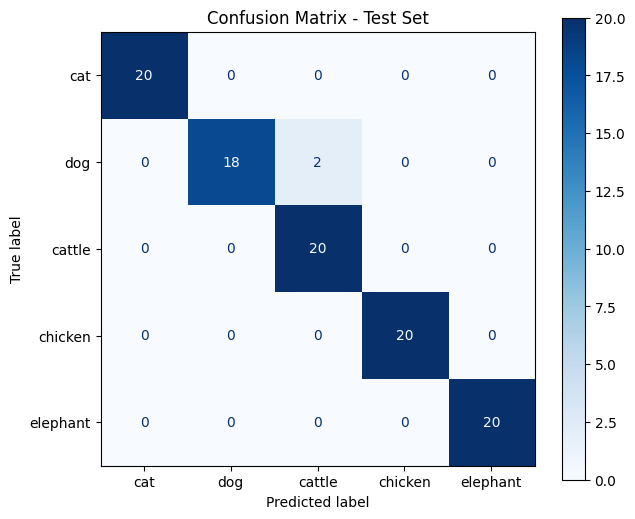

In [22]:
# Cell 8: Confusion Matrix (Test)
_, _, preds, labels = evaluate_split(data_split, "test", predict_species)
cm = confusion_matrix(labels, preds, labels=species_classes)
disp = ConfusionMatrixDisplay(cm, display_labels=species_classes)
plt.figure(figsize=(7,6))
disp.plot(cmap="Blues", ax=plt.gca())
plt.title("Confusion Matrix - Test Set")
plt.show()


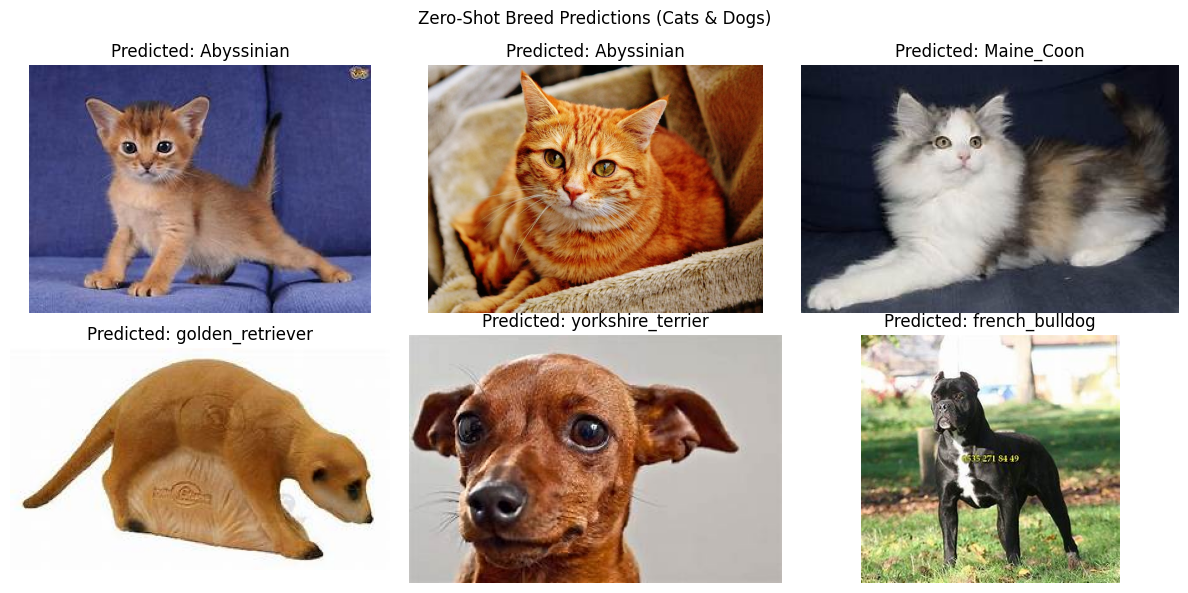

In [23]:
# Cell 10: Zero-shot dự đoán breed (mèo & chó)
breed_imgs = []
for animal in ["cat", "dog"]:
    breed_imgs += random.sample(data_split["test"][animal], min(3, len(data_split["test"][animal])))

plt.figure(figsize=(12,6))
for i, img_path in enumerate(breed_imgs):
    pred_breed = predict_breed(img_path)
    img = Image.open(img_path)
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(f"Predicted: {pred_breed}")
    plt.axis('off')
plt.suptitle("Zero-Shot Breed Predictions (Cats & Dogs)")
plt.tight_layout()
plt.show()


In [24]:
# ============================================================
# 🐾 Cell 11: Hàm dự đoán 1 ảnh duy nhất
# ============================================================

def predict_single_image(img_path, show=True):
    """
    Dự đoán loài (5 lớp) và breed (nếu là chó/mèo)
    """
    # Load ảnh
    image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

    # Encode ảnh
    with torch.no_grad():
        img_feat = model.encode_image(image)
        img_feat /= img_feat.norm(dim=-1, keepdim=True)

        # So khớp với text embeddings 5 loài
        sim_species = (img_feat @ species_text_features.T).squeeze(0)
        species_idx = sim_species.topk(1).indices.item()
        predicted_species = species_classes[species_idx]

        # Nếu là chó/mèo → Zero-shot breed
        predicted_breed = None
        if predicted_species in ["dog", "cat"]:
            sim_breed = (img_feat @ breed_text_features.T).squeeze(0)
            breed_idx = sim_breed.topk(1).indices.item()
            predicted_breed = all_breeds[breed_idx]

    # Hiển thị kết quả
    if show:
        img = Image.open(img_path)
        plt.figure(figsize=(4,4))
        plt.imshow(img)
        title = f"Predicted Species: {predicted_species}"
        if predicted_breed:
            title += f"\nPredicted Breed: {predicted_breed}"
        plt.title(title)
        plt.axis('off')
        plt.show()

    return predicted_species, predicted_breed


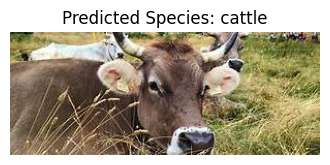

==> Loài: cattle
==> Giống: None


In [29]:
# Ví dụ test 1 ảnh bất kỳ
img_test = data_split["test"]["cattle"][0]  # lấy 1 ảnh chó từ tập test
species, breed = predict_single_image(img_test)
print("==> Loài:", species)
print("==> Giống:", breed)


In [30]:
!cp /kaggle/working/__notebook_source__.ipynb /kaggle/working/my_notebook.ipynb


cp: cannot stat '/kaggle/working/__notebook_source__.ipynb': No such file or directory
